In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import random
from torch.optim import LBFGS
from torch.optim import Adam
from tqdm import tqdm
import scipy.io
import pandas as pd
import pickle
from pyDOE import lhs
import math
import time
import torch.nn.functional as F
import pickle

seed = 0
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

#CUDA support
if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')

In [2]:
def get_n_params(model):
    pp=0
    for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    return pp

In [3]:
# class NN_rho(nn.Module):
#     def __init__(self, in_dim, hidden_dim, out_dim, num_layer):
#         super(NN_rho, self).__init__()

#         layers = []
#         for i in range(num_layer-1):
#             if i == 0:
#                 layers.append(nn.Linear(in_features=in_dim, out_features=hidden_dim))
#                 layers.append(nn.Tanh())
#             else:
#                 layers.append(nn.Linear(in_features=hidden_dim, out_features=hidden_dim))
#                 layers.append(nn.Tanh())

#         layers.append(nn.Linear(in_features=hidden_dim, out_features=out_dim))

#         self.linear = nn.Sequential(*layers)

#     def forward(self, x, t):
#         src = torch.cat((x, t), dim=-1)
#         out = self.linear(src)
#         out = torch.clamp(out, min=0.03, max=0.5)
#         return out
    
# class NN_u(nn.Module):
#     def __init__(self, in_dim, hidden_dim, out_dim, num_layer):
#         super(NN_u, self).__init__()

#         layers = []
#         for i in range(num_layer-1):
#             if i == 0:
#                 layers.append(nn.Linear(in_features=in_dim, out_features=hidden_dim))
#                 layers.append(nn.Tanh())
#             else:
#                 layers.append(nn.Linear(in_features=hidden_dim, out_features=hidden_dim))
#                 layers.append(nn.Tanh())

#         layers.append(nn.Linear(in_features=hidden_dim, out_features=out_dim))

#         self.linear = nn.Sequential(*layers)

#     def forward(self, x, t):
#         src = torch.cat((x, t), dim=-1)
#         out = self.linear(src)
#         out = torch.clamp(out, min=0.01, max=30)
#         return out
    
class VAE_rho(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE_rho, self).__init__()
        self.latent_dim = latent_dim
        # 编码器
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim * 2),  # 输出均值和方差的参数
            nn.Tanh(),
            nn.Linear(hidden_dim * 2, hidden_dim * 4),
            nn.Tanh(),
            nn.Linear(hidden_dim * 4, latent_dim * 2)
        )
        
        # 解码器
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim * 4),
            nn.Tanh(),
            nn.Linear(hidden_dim * 4, hidden_dim * 2),
            nn.Tanh(),
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.Tanh(),
            # nn.Linear(latent_dim, hidden_dim),
            # nn.Tanh(),
            nn.Linear(hidden_dim, 1)  # 输出单个值
        )
    
    def reparameterization(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def forward(self, x):
        # 编码器输出均值和方差
        h = self.encoder(x)
        mu = h[:, :self.latent_dim]
        logvar = h[:, self.latent_dim:]
        
        # 重参数化技巧
        z = self.reparameterization(mu, logvar)
        
        # 解码器输出原始值
        x_recon_raw = self.decoder(z)
        
        # 使用裁剪函数将输出限制在0.03到0.5之间
        # x_recon_clamped = torch.clamp(x_recon_raw, min=0.051, max=0.54)
        x_recon_clamped = x_recon_raw
        return x_recon_clamped, mu, logvar

#      def loss(self, x_recon_clamped, x, mu, logvar):
#         # 计算重构损失
#         reconstruction_loss = F.mse_loss(x_recon_clamped, x)
        
#         # 计算KL散度损失
#         # 均值和方差应该是独立的，所以KL散度的计算是均值的平方加上方差的对数
#         # 然后减去1并乘以0.5
#         kl_divergence_vae = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        
#         # 总损失是重构损失和KL散度损失的加权和
#         loss = reconstruction_loss + kl_divergence_vae
        
#         return lossVAE

class VAE_u(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE_u, self).__init__()
        self.latent_dim = latent_dim
        # 编码器
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim * 2),  
            nn.Tanh(),
            nn.Linear(hidden_dim * 2, hidden_dim * 4),
            nn.Tanh(),
            nn.Linear(hidden_dim * 4, latent_dim * 2)
        )
        
        # 解码器
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim * 4),
            nn.Tanh(),
            nn.Linear(hidden_dim * 4, hidden_dim * 2),
            nn.ReLU(),
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)  # 输出单个值
        )
    
    def reparameterization(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def forward(self, x):
        # 编码器输出均值和方差
        h = self.encoder(x)
        
        mu = h[:, :self.latent_dim]
        logvar = h[:, self.latent_dim:]
        
        # 重参数化技巧
        z = self.reparameterization(mu, logvar)
        
        # 解码器输出原始值
        x_recon_raw = self.decoder(z)
        
        # x_recon_clamped = torch.clamp(x_recon_raw, min=0.1, max=30)
        
        return x_recon_raw, mu, logvar
    

class stochastic_processes():
    def __init__(self):
        with open('US101_Lane1to5_t1.5s30.pickle', 'rb') as f:
            data = pickle.load(f)

        rhoMat = np.array([np.array(ele) for ele in data['rhoMat']])
        uMat = np.array([np.array(ele) for ele in data['vMat']])
        Exact_rho = rhoMat.T
        Exact_u = uMat.T
        rho_star = Exact_rho.flatten()[:, None]
        u_star = Exact_u.flatten()[:, None]

        x = rho_star
        y = u_star
        num_bins = 20
        bin_edges = np.linspace(0.05, 0.6, num_bins + 1)

        # 计算每个小区间x的均值
        self.bin_means_x = [(bin_edges[i] + bin_edges[i + 1]) / 2 for i in range(num_bins)]
        self.bin_max = [y[(x >= bin_edges[i]) & (x < bin_edges[i + 1])].max() for i in range(num_bins)]

        # 统计每个小区间内的散点数值和计算均值
        bin_counts = np.histogram(x, bins=bin_edges)[0]
        self.bin_means = [np.mean(
            y[(x >= bin_edges[i]) & (x < bin_edges[i + 1])] / y[(x >= bin_edges[i]) & (x < bin_edges[i + 1])].max()) for
                     i in range(num_bins)]

        # 计算方差
        self.bin_variances = [np.var(
            y[(x >= bin_edges[i]) & (x < bin_edges[i + 1])] / y[(x >= bin_edges[i]) & (x < bin_edges[i + 1])].max()) for
                         i in range(num_bins)]
        
    def load_ngsim(self, rho):

        fundamental_values = []

        def beta_pdf(a, b, vf):
            return vf * (np.random.beta(a, b, 10))

        for j in rho:
            x_values = j
            x_values_np = x_values.cpu().detach().numpy()
            min_diff_idx = np.argmin(np.abs(np.array(self.bin_means_x) - x_values_np))
            a = -(self.bin_means[min_diff_idx] * self.bin_variances[min_diff_idx] + self.bin_means[min_diff_idx] ** 3 -
                  self.bin_means[
                      min_diff_idx] ** 2) / (self.bin_variances[min_diff_idx])
            b = ((self.bin_means[min_diff_idx] - 1) * self.bin_variances[min_diff_idx] + self.bin_means[
                min_diff_idx] ** 3 - 2 * self.bin_means[
                     min_diff_idx] ** 2 + self.bin_means[min_diff_idx]) / (self.bin_variances[min_diff_idx])

            pdf_values = beta_pdf(a, b, self.bin_max[min_diff_idx])
            fundamental_values.append(pdf_values)
        return fundamental_values


In [4]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import random
from torch.optim import LBFGS
from tqdm import tqdm
import pickle
from pyDOE import lhs

seed = 2024
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

# ----------------- ngsim ------------------
# 读取pkl文件,rb是读取二进制文件，而r是读取文本文件
file = open('US101_Lane1to5_t1.5s30.pickle', 'rb')
info = pickle.load(file)
speed = info['vMat'].T
# speed = speed[:1000,:]
density = info['rhoMat'].T
# density = density[:1000,:]
t=info['t']
# t=t[:1000]
x=info['s']
X, T = np.meshgrid(x,t)
X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
lb = X_star.min(0)
ub = X_star.max(0)

m = 12
if m == 12:
    loopidx = [0,1,3,5,7,9,11,13,15,17,19,20]
else:
    gap = int(len(x)/(m-1))
    loopidx = [i*gap for i in range(m-1)]
    loopidx.append(len(x)-1)# u_star = Exact.flatten()[:,None]   

# loopidx = [0,20] #2个
# loopidx = [0,10,20] #3个
# loopidx = [0,7,14,20] #4个
# loopidx = [0,5,10,15,20] #5个
# loopidx = [0,4,8,12,16,20] #6个
# loopidx = [0,4,7,10,13,16,20] #7个
# loopidx = [0,3,6,9,12,15,17,20] #8个
# loopidx = [0,3,6,9,12,15,17,19,20] #9个
# loopidx = [0,2,4,6,8,10,13,16,18,20] #10个
# loopidx = [0,2,4,6,8,10,12,14,16,18,20] #11个
# loopidx = [0,1,3,5,7,9,11,13,15,17,19,20] #12个
# loopidx = [0,1,3,5,7,9,10,12,14,15,16,18,20] #13个
# loopidx = [0,1,2,4,5,7,9,11,13,14,16,18,19,20] #14个
span = np.array(loopidx)
train_xt = np.hstack([np.meshgrid(np.array(x)[span],t)[0].reshape(-1,1), np.meshgrid(np.array(x)[span],t)[1].reshape(-1,1)])
train_speed=speed[:, span].reshape(-1,1)
train_density=density[:, span].reshape(-1,1)
combined_arr = np.concatenate((train_speed,train_density), axis=1)
train1 = pd.DataFrame(combined_arr, columns=['speed', 'density'])

train = train1.loc[:,['speed', 'density']].values

test_xt = X_star

test_speed=speed.reshape(-1,1)
test_density=density.reshape(-1,1)
combined_arr2 = np.concatenate((test_speed,test_density), axis=1)
test2 = pd.DataFrame(combined_arr2, columns=['speed', 'density'])
test = test2.loc[:,['speed', 'density']].values
# Nf = int(37170 * 1)
idx = np.random.choice(test_xt.shape[0], int(test_xt.shape[0] * 0.2), replace=False)
X_f_train = test_xt[idx, :]
# X_f_train = lb + (ub-lb)*lhs(2, Nf)
# X_f_train = np.vstack((X_f_train, train_xt))
# X_f_train = np.unique(X_f_train,axis=0)
print(X_f_train.shape)

train_xt = (train_xt - lb)/(ub - lb)
X_star = (X_star - lb)/(ub - lb) 
X_f_train = (X_f_train - lb)/(ub - lb)

train_xt = torch.tensor(train_xt, dtype=torch.float32, requires_grad=True).to(device)
X_f_train_rho = torch.tensor(X_f_train, dtype=torch.float32, requires_grad=True).to(device)
X_f_train_u = torch.tensor(X_f_train, dtype=torch.float32, requires_grad=True).repeat(10,1).to(device)
train = torch.tensor(train, dtype=torch.float32, requires_grad=True).to(device)
X_star = torch.tensor(X_star, dtype=torch.float32, requires_grad=True).to(device)
test = torch.tensor(test, dtype=torch.float32, requires_grad=True).to(device)
train_rho = train[:,1].unsqueeze(1)
train_u = train[:,0].unsqueeze(1)
# # ------------------ end -------------------

# 创建VAE模型
vae_rho = VAE_rho(input_dim=2, hidden_dim=32, latent_dim=32).to(device)

vae_u = VAE_u(input_dim=2, hidden_dim=32, latent_dim=32).to(device)

optimizer = torch.optim.Adam(list(vae_rho.parameters()) + list(vae_u.parameters()), lr=0.0005)

model_ni = stochastic_processes()
# model_ni = StochasticProcesses('US101_Lane1to5_t1.5s30.pickle')

(7434, 2)


In [5]:
loss_track = []

for i in tqdm(range(10000)):
    def closure():
        
        pred_res_rho,mean_rho,var_rho = vae_rho(train_xt)               #赋给mean_rho和var_rho的分别是vae_rho的输出mu（均值）, logvar（方差的对数）
        pred_res_f_rho,mean_rho_f, var_rho_f= vae_rho(X_f_train_rho)
        kl_divergence_rho = -0.5 * torch.sum(1 + var_rho - mean_rho.pow(2) - var_rho.exp())   
        
        pred_res_u,mean_u,var_u = vae_u(train_xt)
        pred_res_f_u,mean_u_f,var_u_f = vae_u(X_f_train_u)
        kl_divergence_u = -0.5 * torch.sum(1 + var_u - mean_u.pow(2) - var_u.exp())

        loss_rho = torch.mean((pred_res_rho - train_rho) ** 2)
        loss_u = torch.mean((pred_res_u - train_u) ** 2)
        
        new_tensor = torch.zeros((7434, 10), device='cuda:0')

        for i in range(10):
            new_tensor[:, i] = pred_res_f_u[i * 7434 : (i + 1) * 7434, 0]
        
        start_time = time.time()
        u_pdf_test = model_ni.load_ngsim(pred_res_f_rho)
        u_pdf_test = torch.tensor(np.array(u_pdf_test)).to(torch.float32).to(device)
        
        # 确保P(x)不为0
        eps = 1e-10
        tensor1 = torch.clamp(u_pdf_test, min=eps)
        tensor2 = torch.clamp(new_tensor, min=eps)
        # 计算KL散度
        kl_divergence = torch.sum(tensor1 * torch.log(tensor1 / tensor2), dim=1)
        # 累加所有行的KL散度
        total_kl_divergence = torch.mean(kl_divergence)
        loss_phy_time = time.time() - start_time
#         loss =   loss_rho +   loss_u     + 0.5 * total_kl_divergence
        loss =   loss_rho +   loss_u     + 0.5 * total_kl_divergence + 0.0001 * kl_divergence_rho + 0.0001 * kl_divergence_u
 
        # print('loss',loss)
#         fundamental = 18.384 * torch.exp(-((pred_res_f[:,1]/0.195)**2)/2)
#         k_t = torch.autograd.grad(pred_res_f[:,1],t_u_f,grad_outputs=torch.ones_like(pred_res_f[:,1]), retain_graph=True, create_graph=True)[0]
#         q = pred_res_f[:,0] * pred_res_f[:,1]
#         q_x = torch.autograd.grad(q,x_u_f,grad_outputs=torch.ones_like(q), retain_graph=True, create_graph=True)[0]
#         d1 = pred_res_f[:,0]-fundamental
#         q1_t = torch.autograd.grad(d1,t_u_f,grad_outputs=torch.ones_like(d1), retain_graph=True, create_graph=True)[0]
#         q2_x = torch.autograd.grad(d1,x_u_f,grad_outputs=torch.ones_like(d1), retain_graph=True, create_graph=True)[0]
        
#         loss_eq1 = torch.mean((k_t + q_x)**2)
#         loss_eq2 = torch.mean((q1_t+pred_res_f[:,0]*q2_x)**2)
#         loss_track.append([loss_res.item(),loss_eq1.item(),loss_eq2.item()])
#         loss = 1000 * loss_res +  0.01* loss_eq1 +  0.01 * loss_eq2
        optimizer.zero_grad()
        loss.backward()
        return loss
    optimizer.step(closure)


100%|██████████| 10000/10000 [1:00:23<00:00,  2.76it/s]


In [6]:
X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
X_star = (X_star - lb)/(ub - lb) 
X_star = torch.tensor(X_star, dtype=torch.float32, requires_grad=True).to(device)


In [7]:

with torch.no_grad():
    pred_rho,_,_ = vae_rho(X_star)
    pred_rho = pred_rho.cpu().detach().numpy()
    
    pred_u,_,_ = vae_u(X_star)
    pred_u = pred_u.cpu().detach().numpy()
print(pred_rho)
print(pred_u)

[[0.21869537]
 [0.20762411]
 [0.18887495]
 ...
 [0.28354383]
 [0.2939884 ]
 [0.30159378]]
[[10.461486 ]
 [10.995442 ]
 [11.795827 ]
 ...
 [ 4.998663 ]
 [ 4.945095 ]
 [ 4.8696856]]


In [8]:
pred_rho.shape

(37170, 1)

In [9]:
true_rho = test_density.reshape(1770,21)
pred_rho = pred_rho.reshape(1770,21)
print(true_rho.shape)
print(pred_rho.shape)

true_u = test_speed.reshape(1770,21)
pred_u = pred_u.reshape(1770,21)
print(true_u.shape)
print(pred_u.shape)

(1770, 21)
(1770, 21)
(1770, 21)
(1770, 21)


In [10]:
path= r'/root/autodl-tmp/result'
import os
np.save(os.path.join(path,'pred_rho'+  '_loop'+str(m) + '.npy'),arr=pred_rho)#######
np.save(os.path.join(path,'pred_u'+  '_loop'+str(m) + '.npy'),arr=pred_u)#######

In [11]:
# 指标计算
# from sklearn import metrics

def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred - y_true) / y_true)) * 100

def mae(true, pred):  
    abs_error = np.abs(true - pred)  
    sum_abs_error = np.sum(abs_error)  
    mae_loss = sum_abs_error / true.size  
    return mae_loss  

def mse(true, pred):  
    squared_error = np.square(true - pred)   
    sum_squared_error = np.sum(squared_error)  
    mse_loss = sum_squared_error / true.size  
    return mse_loss  

def rmse(true, pred):  
    squared_error = np.square(true - pred)   
    sum_squared_error = np.sum(squared_error)  
    rmse_loss = np.sqrt(sum_squared_error / true.size)  
    return rmse_loss  

#------- 速度 -----------
# MSE
print('MSE-速度：',round(mse(true_u, pred_u),4)) 
# RMSE
print('RMSE-速度：',round(rmse(true_u, pred_u),4))
# MAE
print("MAE-速度：",round(mae(true_u, pred_u),4)) 
# MAPE
print("MAPE-速度：",round(mape(true_u, pred_u),4)) 

error_speed = np.linalg.norm(true_u-pred_u,2)/np.linalg.norm(true_u,2)
print('Error speed: %e' % (error_speed))

#-------- 密度 -----------
# MSE
print('MSE-密度：',round(mse(true_rho, pred_rho),4)) 
# RMSE
print('RMSE-密度：',round(rmse(true_rho, pred_rho),4)) 
# MAE
print("MAE-密度：",round(mae(true_rho, pred_rho),4)) 
# MAPE
print("MAPE-密度：",round(mape(true_rho, pred_rho),4)) 

error_density = np.linalg.norm(true_rho-pred_rho,2)/np.linalg.norm(true_rho,2)
print('Error density: %e' % (error_density))

MSE-速度： 0.5997
RMSE-速度： 0.7744
MAE-速度： 0.601
MAPE-速度： 7.8154
Error speed: 2.571602e-02
MSE-密度： 0.0012
RMSE-密度： 0.0341
MAE-密度： 0.0269
MAPE-密度： 14.7487
Error density: 4.463630e-02


In [12]:
import numpy as np
import matplotlib as mpl
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
#mpl.use('pgf')

def figsize(scale, nplots = 1):
    fig_width_pt = 390.0                          # Get this from LaTeX using \the\textwidth
    inches_per_pt = 1.0/72.27                       # Convert pt to inch
    golden_mean = (np.sqrt(5.0)-1.0)/2.0            # Aesthetic ratio (you could change this)
    fig_width = fig_width_pt*inches_per_pt*scale    # width in inches
    fig_height = nplots*fig_width*golden_mean              # height in inches
    fig_size = [fig_width,fig_height]
    return fig_size

pgf_with_latex = {                      # setup matplotlib to use latex for output
    "pgf.texsystem": "pdflatex",        # change this if using xetex or lautex
    "text.usetex": True,                # use LaTeX to write all text
    "font.family": "serif",
    "font.serif": [],                   # blank entries should cause plots to inherit fonts from the document
    "font.sans-serif": [],
    "font.monospace": [],
    "axes.labelsize": 10,               # LaTeX default is 10pt font.
    "font.size": 10,
    "legend.fontsize": 8,               # Make the legend/label fonts a little smaller
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
    "figure.figsize": figsize(1.0),     # default fig size of 0.9 textwidth
    "pgf.preamble": [
        r"\usepackage[utf8x]{inputenc}",    # use utf8 fonts becasue your computer can handle it :)
        r"\usepackage[T1]{fontenc}",        # plots will be generated using this preamble
        ]
    }
#mpl.rcParams.update(pgf_with_latex)

import matplotlib.pyplot as plt

# I make my own newfig and savefig functions
def newfig(width, nplots = 1):
    fig = plt.figure(figsize=figsize(width, nplots))
    ax = fig.add_subplot(111)
    return fig, ax

def savefig(filename, crop = True):
    if crop == True:
#        plt.savefig('{}.pgf'.format(filename), bbox_inches='tight', pad_inches=0)
        plt.savefig('{}.pdf'.format(filename), bbox_inches='tight', pad_inches=0)
        plt.savefig('{}.eps'.format(filename), bbox_inches='tight', pad_inches=0)
    else:
#        plt.savefig('{}.pgf'.format(filename))
        plt.savefig('{}.pdf'.format(filename))
        plt.savefig('{}.eps'.format(filename))

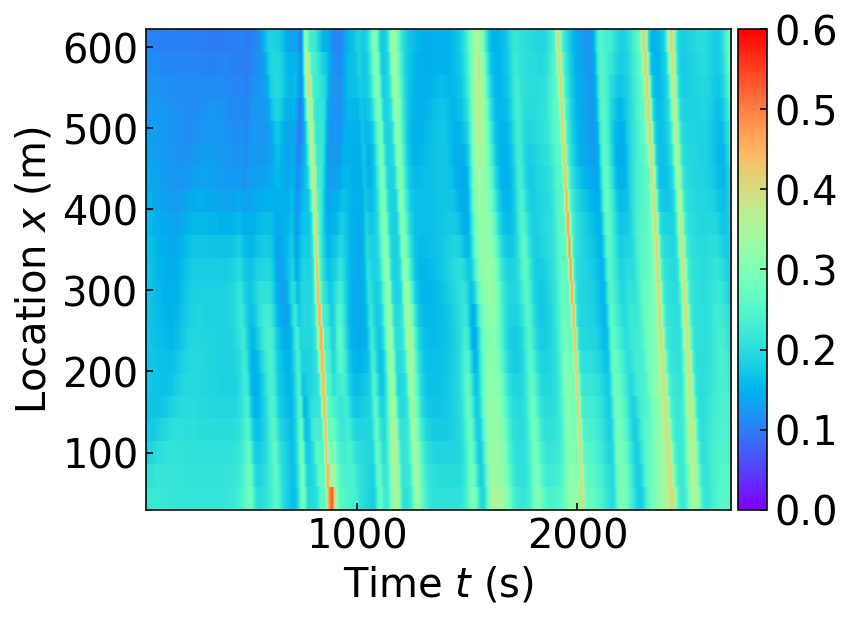

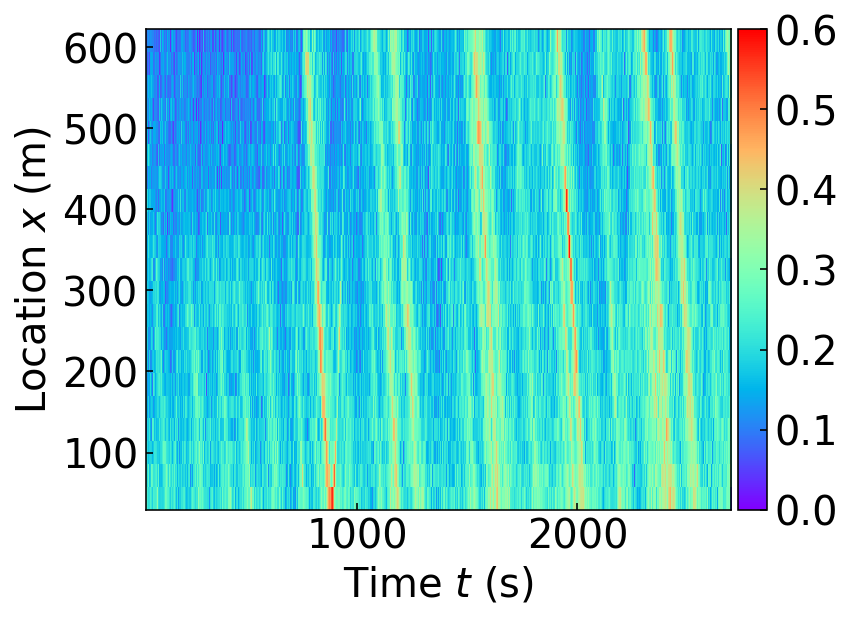

In [13]:
plt.rcParams['xtick.direction'] = 'in'#将x周的刻度线方向设置向内
plt.rcParams['ytick.direction'] = 'in'#将y轴的刻度方向设置向内
## 输出高清图像
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
fig, ax = newfig(4,2)
ax.axis('off')

####### Row 1: PIDL: u(t,x) ##################  
# x = data.iloc[:23,1] # 这里选取了23个传感器 0-16
# t = np.linspace(0.083, 168, 2016) # 把一天24小时按5分钟划分

gs0 = gridspec.GridSpec(4, 2)
gs0.update(top=1, bottom=7/8, left=0.2, right=0.4, wspace=0)
ax = plt.subplot(gs0[:, :])
ax.tick_params(axis='both', which='major', labelsize=20)

h = ax.imshow(pred_rho.T, interpolation='nearest', cmap='rainbow', 
              extent=[min(t), max(t), min(x), max(x)],vmin=0,vmax=0.6,
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cax.tick_params(labelsize=20)
fig.colorbar(h, cax=cax)

# ax.plot(train_xt[:,1], train_xt[:,0], 'kx', markersize = 2, clip_on = False)
# ax.set_ylim(0, 65)
# ax.set_yticks([0,20,40,60])
# ax.set_xlim([0, 516])
# ax.set_xticks([0,100,200,300,400,500])
# ax.set_xticklabels(labels=[0,100,200,300,400,500], rotation=90)  # 旋转90度
ax.set_xlabel('Time $t$ (s)', fontsize = 20)
ax.set_ylabel('Location $x$ (m)', fontsize = 20)
# ax.legend(frameon=False, loc = 'best', fontsize = 20)
# ax.set_title('4_loop $v(x,t)$ (m./s)', fontsize = 20,pad=20)
fig.savefig("heatmap_predicted_rho.png", dpi=400, bbox_inches='tight')
plt.show()

####### Row 2: PIDL: u(t,x) ##################  
plt.rcParams['xtick.direction'] = 'in'#将x周的刻度线方向设置向内
plt.rcParams['ytick.direction'] = 'in'#将y轴的刻度方向设置向内
fig, ax = newfig(4,2)
ax.axis('off')
gs0 = gridspec.GridSpec(4, 2)
gs0.update(top=1, bottom=7/8, left=0.6, right=0.8, wspace=0)
ax = plt.subplot(gs0[:, :])
ax.tick_params(axis='both', which='major', labelsize=20)

h = ax.imshow(true_rho[:,:].T, interpolation='nearest', cmap='rainbow', 
              extent=[min(t), max(t), min(x), max(x)],vmin=0,vmax=0.6,
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cax.tick_params(labelsize=20)
fig.colorbar(h, cax=cax)

#ax.plot(X_u_train[:,1], X_u_train[:,0], 'kx', markersize = 2, clip_on = False)
# ax.set_ylim(0, 200)
# ax.set_yticks([0,50,100,150,200])
# ax.set_xlim([0, 516])
# ax.set_xticks([0,100,200,300,400,500])
# ax.set_xticklabels(labels=[0,100,200,300,400,500], rotation=90)  # 旋转90度
ax.set_xlabel('Time $t$ (s)', fontsize = 20)
ax.set_ylabel('Location $x$ (m)', fontsize = 20)
# ax.legend(frameon=False, loc = 'best', fontsize = 20)
# ax.set_title('6_loop $v(x,t)$ (m./s)', fontsize = 20,pad=20)
fig.savefig("heatmap_true_rho.png", dpi=400, bbox_inches='tight')
plt.show()

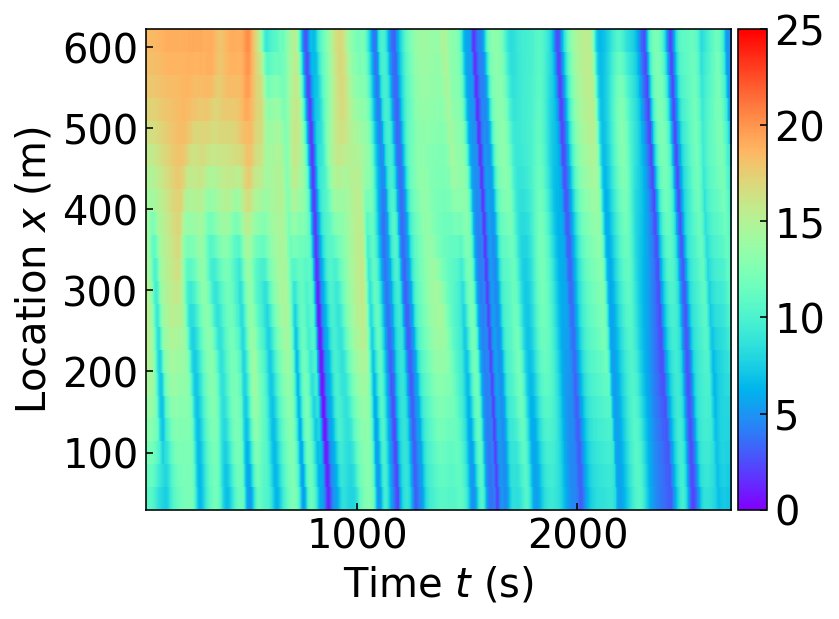

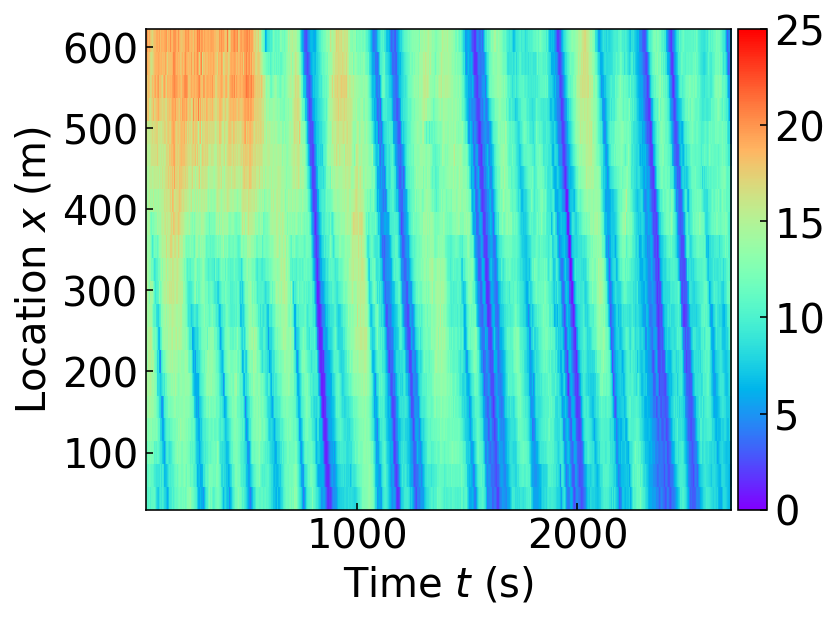

In [14]:
plt.rcParams['xtick.direction'] = 'in'#将x周的刻度线方向设置向内
plt.rcParams['ytick.direction'] = 'in'#将y轴的刻度方向设置向内
## 输出高清图像
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
fig, ax = newfig(4,2)
ax.axis('off')

####### Row 1: PIDL: u(t,x) ##################  
# x = data.iloc[:23,1] # 这里选取了23个传感器 0-16
# t = np.linspace(0.083, 168, 2016) # 把一天24小时按5分钟划分

gs0 = gridspec.GridSpec(4, 2)
gs0.update(top=1, bottom=7/8, left=0.2, right=0.4, wspace=0)
ax = plt.subplot(gs0[:, :])
ax.tick_params(axis='both', which='major', labelsize=20)

h = ax.imshow(pred_u.T, interpolation='nearest', cmap='rainbow', 
              extent=[min(t), max(t), min(x), max(x)],vmin=0,vmax=25,
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cax.tick_params(labelsize=20)
fig.colorbar(h, cax=cax)

# ax.plot(train_xt[:,1], train_xt[:,0], 'kx', markersize = 2, clip_on = False)
# ax.set_ylim(0, 65)
# ax.set_yticks([0,20,40,60])
# ax.set_xlim([0, 516])
# ax.set_xticks([0,100,200,300,400,500])
# ax.set_xticklabels(labels=[0,100,200,300,400,500], rotation=90)  # 旋转90度
ax.set_xlabel('Time $t$ (s)', fontsize = 20)
ax.set_ylabel('Location $x$ (m)', fontsize = 20)
# ax.legend(frameon=False, loc = 'best', fontsize = 20)
# ax.set_title('4_loop $v(x,t)$ (m./s)', fontsize = 20,pad=20)
fig.savefig("heatmap_predicted_velocity.png", dpi=400, bbox_inches='tight')
plt.show()

####### Row 2: PIDL: u(t,x) ##################  
plt.rcParams['xtick.direction'] = 'in'#将x周的刻度线方向设置向内
plt.rcParams['ytick.direction'] = 'in'#将y轴的刻度方向设置向内
fig, ax = newfig(4,2)
ax.axis('off')
gs0 = gridspec.GridSpec(4, 2)
gs0.update(top=1, bottom=7/8, left=0.6, right=0.8, wspace=0)
ax = plt.subplot(gs0[:, :])
ax.tick_params(axis='both', which='major', labelsize=20)

h = ax.imshow(true_u[:,:].T, interpolation='nearest', cmap='rainbow', 
              extent=[min(t), max(t), min(x), max(x)],vmin=0,vmax=25,
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cax.tick_params(labelsize=20)
fig.colorbar(h, cax=cax)

#ax.plot(X_u_train[:,1], X_u_train[:,0], 'kx', markersize = 2, clip_on = False)
# ax.set_ylim(0, 200)
# ax.set_yticks([0,50,100,150,200])
# ax.set_xlim([0, 516])
# ax.set_xticks([0,100,200,300,400,500])
# ax.set_xticklabels(labels=[0,100,200,300,400,500], rotation=90)  # 旋转90度
ax.set_xlabel('Time $t$ (s)', fontsize = 20)
ax.set_ylabel('Location $x$ (m)', fontsize = 20)
# ax.legend(frameon=False, loc = 'best', fontsize = 20)
# ax.set_title('6_loop $v(x,t)$ (m./s)', fontsize = 20,pad=20)
fig.savefig("heatmap_true_velocity.png", dpi=400, bbox_inches='tight')
plt.show()

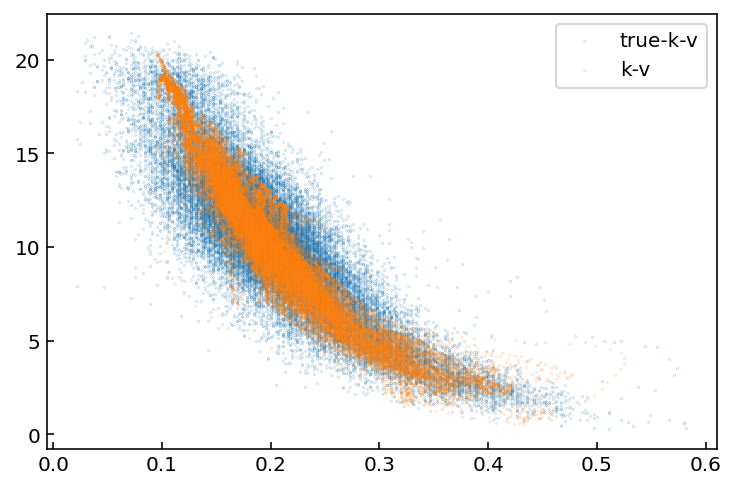

In [15]:
plt.scatter(density.flatten(),speed.flatten(),s=0.01,label='true-k-v')
plt.scatter(pred_rho.flatten(),pred_u.flatten(),s=0.01,label="k-v")
plt.legend()
plt.savefig("FD.png", dpi=400, bbox_inches='tight')

In [16]:

import pickle
# 读取pkl文件,rb是读取二进制文件，而r是读取文本文件
file = open('US101_Lane1to5_t1.5s30.pickle', 'rb')
info = pickle.load(file)
speed=info['vMat'].T
density = info['rhoMat'].T
flat_arrayv = speed.flatten()
flat_arrayrho = density.flatten()
# v_lb,v_ub,rho_lb,rho_ub = min(flat_arrayv),max(flat_arrayv),min(flat_arrayrho),max(flat_arrayrho)
# flat_array1 = (flat_arrayv-v_lb)/(v_ub-v_lb)
# flat_array2 = (flat_arrayrho-rho_lb)/(rho_ub-rho_lb)

t=info['t']
x=info['s']

pred_rho = np.load('result/pred_rho_loop6.npy')
pred_u = np.load('result/pred_u_loop6.npy')

In [17]:
x = pred_rho.flatten()
y = pred_u.flatten()

In [18]:
# --------------------估计的------------------------
# 划分横轴为10个小区间
num_bins = 100
bin_edges = np.linspace(0.03, 0.6, num_bins + 1)

# 计算每个小区间x的均值
bin_means_x = [(bin_edges[i] + bin_edges[i + 1]) / 2 for i in range(num_bins)]

# 统计每个小区间内的散点数值和计算均值
bin_counts = np.histogram(x, bins=bin_edges)[0]
bin_means = [np.mean(y[(x >= bin_edges[i]) & (x < bin_edges[i + 1])]) for i in range(num_bins)]

# 计算方差
bin_variances = [np.var(y[(x >= bin_edges[i]) & (x < bin_edges[i + 1])]) for i in range(num_bins)]
 # ------------------------ 真实的 ------------------------
    
# 统计每个小区间内的散点数值和计算均值
true_bin_counts = np.histogram(flat_arrayrho, bins=bin_edges)[0]
true_bin_means = [np.mean(flat_arrayv[(flat_arrayrho >= bin_edges[i]) & (flat_arrayrho < bin_edges[i + 1])]) for i in range(num_bins)]

# 计算方差
true_bin_variances = [np.var(flat_arrayv[(flat_arrayrho >= bin_edges[i]) & (flat_arrayrho < bin_edges[i + 1])]) for i in range(num_bins)]

/root/miniconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/root/miniconda3/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/root/miniconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3757: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/root/miniconda3/lib/python3.8/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/root/miniconda3/lib/python3.8/site-packages/numpy/core/_methods.py:256: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/root/miniconda3/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value

最优参数 vf_lsm: 20.0
最优参数 kc_lsm: 0.15423538222526817
最优参数 m: 4.0


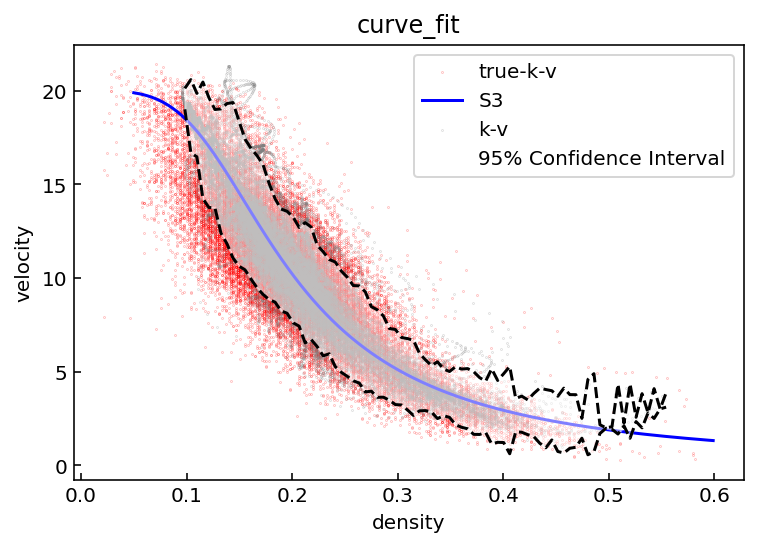

In [19]:
import numpy as np
from scipy.optimize import minimize

# def func2(k, vc,kj): # GB
#     return vc * np.log(kj/k)

def func2(k, vf, kc, m): # S3
    return vf/(1+(k/kc)**m)**(2/m)

# 定义目标函数
def objective_lsm(params, x_data, y_data):
    vc,kj,m = params
    y_hat = func2(x_data, vc,kj,m)
    error = y_data - y_hat
    weighted_error = error
    cost = np.sum(weighted_error ** 2)
    return cost

# 初始参数猜测值
initial_guess = [20.0, 0.2,4]
# 使用优化算法找到最优参数
result_lsm = minimize(objective_lsm, initial_guess, args=(x, y))
vf_optimal_lsm, kc_optimal_lsm,m = result_lsm.x
print("最优参数 vf_lsm:", vf_optimal_lsm)
print("最优参数 kc_lsm:", kc_optimal_lsm)
print("最优参数 m:", m)

xx2 = np.arange(0.05, 0.6, 0.001)
x2 = bin_means_x
y2 = bin_means

yy2_mean = func2(xx2,vf_optimal_lsm,kc_optimal_lsm,m)

# plt.plot(bin_means_x,bin_means,label='Mean')

# 置信水平（这里使用95%置信水平）
confidence_level = 0.95 # 1.96; 85% -> 1.44
lower_bound_v_list = []
upper_bound_v_list = []
for i in range(100):
    # 计算标准差（方差的平方根）
    std_dev_v = np.sqrt(bin_variances[i])
    v_mean_arrayv = bin_means[i]
    # 计算置信区间的上下界
    margin_of_error_v = 1.96 * (std_dev_v)  # 对应95%置信水平的Z值
    lower_bound_v = v_mean_arrayv - margin_of_error_v
    upper_bound_v = v_mean_arrayv + margin_of_error_v
    lower_bound_v_list.append(lower_bound_v)
    upper_bound_v_list.append(upper_bound_v)
    
plt.scatter(flat_arrayrho,flat_arrayv,s=0.01,color='red',label='true-k-v')
plt.plot(xx2, yy2_mean,'b',label='S3')

plt.scatter(x,y,s=0.01,color='grey',label='k-v')
# plt.scatter(x2, y2, marker='o',label='original values')
# plt.plot(bin_edges[1:], bin_means,'b',label='Mean')
plt.fill_between(bin_edges[1:], lower_bound_v_list, upper_bound_v_list, color='white', alpha=0.5, zorder=2,label='95% Confidence Interval')
# 添加黑色虚线作为上下界
# 绘制虚线作为上下界
plt.plot(bin_edges[1:], upper_bound_v_list, 'k--')
plt.plot(bin_edges[1:], lower_bound_v_list, 'k--')
plt.xlabel('density')
plt.ylabel('velocity')
plt.title('curve_fit')
plt.legend()
plt.savefig("FD_CI.png", dpi=400, bbox_inches='tight')
plt.show()

In [20]:
bin_variances

[nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 0.081599094,
 0.99489766,
 0.745934,
 2.5213163,
 2.236639,
 1.787993,
 2.8612545,
 3.6423612,
 4.4794536,
 3.9051275,
 3.1655455,
 3.162888,
 3.2387931,
 3.1204042,
 2.5041652,
 1.9832873,
 1.9202574,
 1.9273163,
 2.0687916,
 1.8081441,
 2.6828058,
 2.3477626,
 1.905637,
 2.009341,
 1.6478009,
 2.0273604,
 1.9029621,
 1.8191947,
 1.6824803,
 1.7515464,
 1.8577585,
 1.3227664,
 1.4196153,
 1.2226244,
 0.9522266,
 1.0458267,
 0.84468716,
 0.9444436,
 1.0475194,
 0.6126562,
 0.47747028,
 0.3986872,
 0.5978213,
 0.40407613,
 0.3908282,
 0.62264115,
 0.6286924,
 0.6706746,
 0.7295169,
 0.59913814,
 0.48607638,
 1.0462868,
 0.70914966,
 0.88007414,
 1.4125459,
 0.20524682,
 0.24206835,
 0.22449322,
 0.34369734,
 0.56411034,
 0.6306001,
 0.44920576,
 0.56673914,
 0.7792599,
 0.5334966,
 0.51279795,
 0.07275046,
 1.0513786,
 1.1291105,
 0.014029772,
 3.820994e-05,
 0.0011624602,
 0.46019164,
 0.0013717228,
 0.5503962,
 0.00349

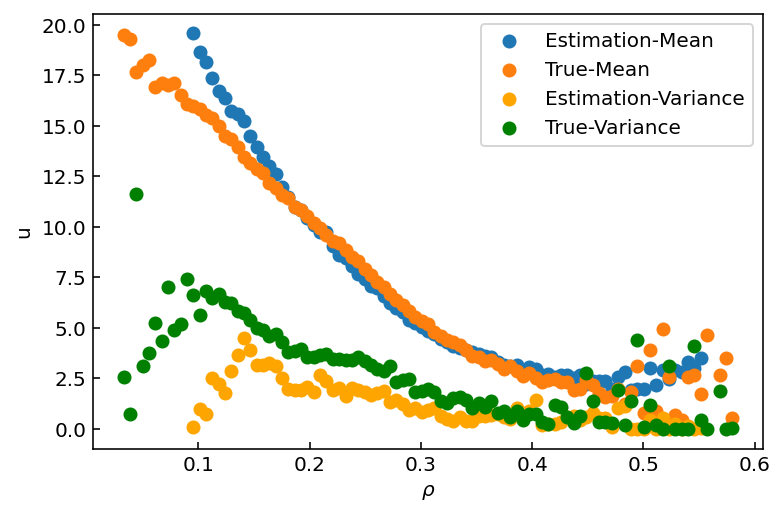

In [21]:
plt.scatter(bin_means_x,bin_means,label='Estimation-Mean')
plt.scatter(bin_means_x,true_bin_means,label='True-Mean')

plt.scatter(bin_means_x,bin_variances,color='orange',label='Estimation-Variance')
plt.scatter(bin_means_x,true_bin_variances,color='green',label='True-Variance')

plt.xlabel(r'$\rho$')
plt.ylabel(r"u")
plt.legend()

plt.savefig("Mean_Var.png", dpi=400, bbox_inches='tight')

In [22]:
X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
X_star = (X_star - lb)/(ub - lb) 
X_star = torch.tensor(X_star, dtype=torch.float32, requires_grad=True).to(device)
with torch.no_grad():
    pred_rho,_,_ = vae_rho(X_star)
    pred_rho = pred_rho.cpu().detach().numpy()
    
    pred_u,_,_ = vae_u(X_star)
    pred_u = pred_u.cpu().detach().numpy()
print(pred_rho)
print(pred_u)

[[0.21759662]
 [0.20234504]
 [0.1849392 ]
 ...
 [0.28556055]
 [0.29577816]
 [0.29501873]]
[[10.415081 ]
 [10.983474 ]
 [11.741368 ]
 ...
 [ 4.988299 ]
 [ 4.9463077]
 [ 4.857851 ]]


In [23]:
data = pd.DataFrame({'v': pred_u.flatten(),
                   'rho': pred_rho.flatten()})

In [24]:
data

,v,rho
0,10.415081,0.217597
1,10.983474,0.202345
2,11.741368,0.184939
3,12.622298,0.175611
4,13.359759,0.169925
...,...,...
37165,5.205891,0.245325
37166,5.070862,0.267775
37167,4.988299,0.285561
37168,4.946308,0.295778


In [25]:
data = data.round(decimals=1)

hist_1 = data[data['rho']==0.1]

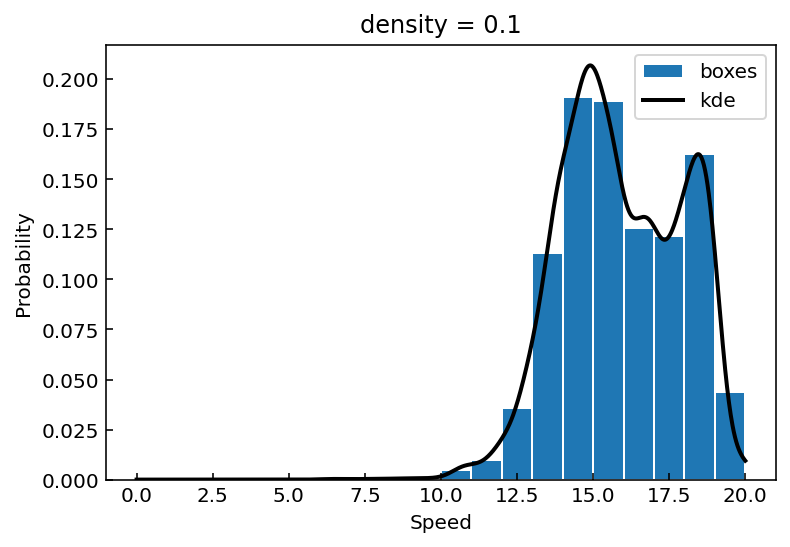

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
plt.rcParams['xtick.direction'] = 'in'#将x周的刻度线方向设置向内
plt.rcParams['ytick.direction'] = 'in'#将y轴的刻度方向设置向内
## 输出高清图像
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
# 绘制直方图
# 定义自己的横轴范围
x_min = 0
x_max = 20

# 计算核密度估计
kde = gaussian_kde(hist_1['v'])
x = np.linspace(x_min, x_max, 1000)
density = kde(x)
# plt.hist(hist_219537['v'], range=(0, 20), edgecolor='black', density=True, alpha=0.7)
plt.hist(hist_1['v'],bins=20,density = True,range=(0, 20),edgecolor ='w',label = 'boxes')
# 绘制概率密度曲线
plt.plot(x, density, color='k', linewidth=2,label='kde')
plt.legend()
plt.xlabel('Speed')
plt.ylabel("Probability")
plt.title("density = 0.1")
plt.savefig("hist_1.png", dpi=400, bbox_inches='tight')


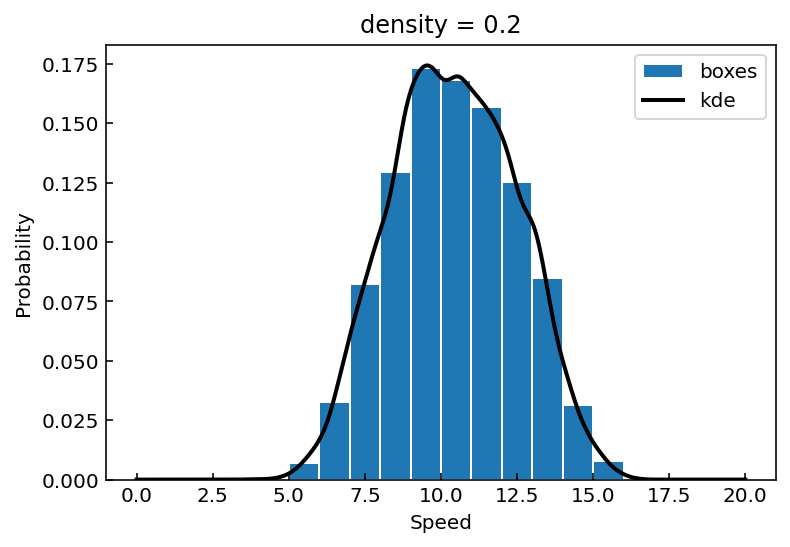

In [27]:
hist_2 = data[data['rho']==0.2]

# 绘制直方图
# 定义自己的横轴范围
x_min = 0
x_max = 20

# 计算核密度估计
kde = gaussian_kde(hist_2['v'])
x = np.linspace(x_min, x_max, 1000)
density = kde(x)
# plt.hist(hist_219537['v'], range=(0, 20), edgecolor='black', density=True, alpha=0.7)
plt.hist(hist_2['v'],bins=20,density = True,range=(0, 20),edgecolor ='w',label = 'boxes')
# 绘制概率密度曲线
plt.plot(x, density, color='k', linewidth=2,label='kde')
plt.legend()
plt.xlabel('Speed')
plt.ylabel("Probability")
plt.title("density = 0.2")
plt.savefig("hist_2.png", dpi=400, bbox_inches='tight')

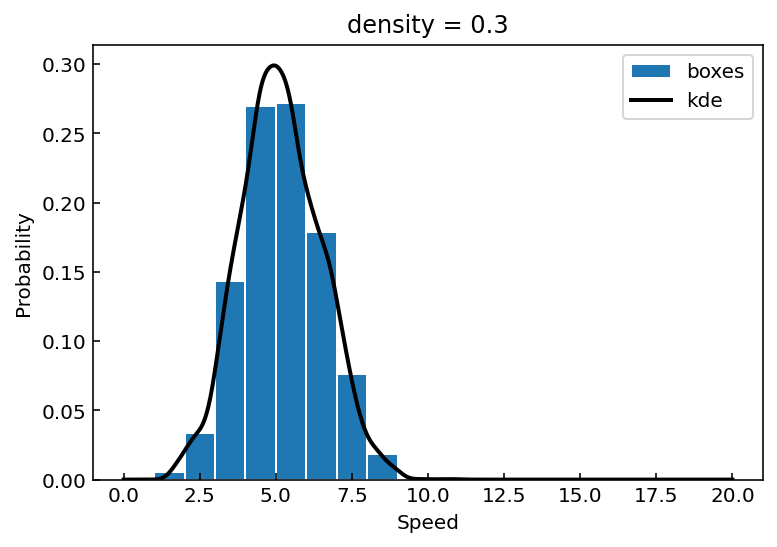

In [28]:
hist_3 = data[data['rho']==0.3]

# 绘制直方图
# 定义自己的横轴范围
x_min = 0
x_max = 20

# 计算核密度估计
kde = gaussian_kde(hist_3['v'])
x = np.linspace(x_min, x_max, 1000)
density = kde(x)
# plt.hist(hist_219537['v'], range=(0, 20), edgecolor='black', density=True, alpha=0.7)
plt.hist(hist_3['v'],bins=20,density = True,range=(0, 20),edgecolor ='w',label = 'boxes')
# 绘制概率密度曲线
plt.plot(x, density, color='k', linewidth=2,label='kde')
plt.legend()
plt.xlabel('Speed')
plt.ylabel("Probability")
plt.title("density = 0.3")
plt.savefig("hist_3.png", dpi=400, bbox_inches='tight')

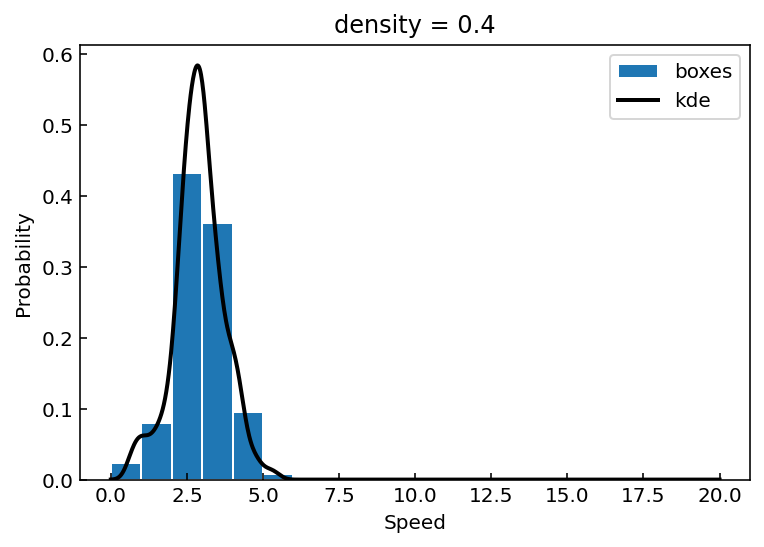

In [29]:
hist_4 = data[data['rho']==0.4]

# 绘制直方图
# 定义自己的横轴范围
x_min = 0
x_max = 20

# 计算核密度估计
kde = gaussian_kde(hist_4['v'])
x = np.linspace(x_min, x_max, 1000)
density = kde(x)
# plt.hist(hist_219537['v'], range=(0, 20), edgecolor='black', density=True, alpha=0.7)
plt.hist(hist_4['v'],bins=20,density = True,range=(0, 20),edgecolor ='w',label = 'boxes')
# 绘制概率密度曲线
plt.plot(x, density, color='k', linewidth=2,label='kde')
plt.legend()
plt.xlabel('Speed')
plt.ylabel("Probability")
plt.title("density = 0.4")
plt.savefig("hist_4.png", dpi=400, bbox_inches='tight')

In [30]:
X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
X_star = (X_star - lb)/(ub - lb) 
X_star = torch.tensor(X_star, dtype=torch.float32, requires_grad=True).repeat(10,1).to(device)

with torch.no_grad():
    pred_rho,_,_ = vae_rho(X_star)
    pred_rho = pred_rho.cpu().detach().numpy()
    
    pred_u,_,_ = vae_u(X_star)
    pred_u = pred_u.cpu().detach().numpy()
print(pred_rho)
print(pred_u)
new_tensor = np.zeros((37170, 10))

for i in range(10):
    new_tensor[:, i] = pred_u[i * 37170 : (i + 1) * 37170, 0]

[[0.21602896]
 [0.20661515]
 [0.18493965]
 ...
 [0.28399497]
 [0.29841682]
 [0.30221713]]
[[10.401708 ]
 [11.052377 ]
 [11.772964 ]
 ...
 [ 4.9911895]
 [ 4.9270883]
 [ 4.855    ]]


In [31]:
new_tensor

array([[10.40170765, 10.42559814, 10.42786217, ..., 10.45118999,
        10.42447567, 10.41922188],
       [11.05237675, 11.03304672, 11.00760078, ..., 10.98822021,
        11.03884029, 11.01057434],
       [11.77296352, 11.72577   , 11.78924084, ..., 11.75658894,
        11.7460928 , 11.82441711],
       ...,
       [ 4.99190521,  5.0104599 ,  4.99715471, ...,  5.00716591,
         4.99291086,  4.99118948],
       [ 4.94984388,  4.94455576,  4.95981598, ...,  4.93929434,
         4.95160103,  4.92708826],
       [ 4.86750412,  4.86803722,  4.86413813, ...,  4.84103155,
         4.86533022,  4.85500002]])

In [32]:
path= r'/root/autodl-tmp/result'
import os
np.save(os.path.join(path,'pred_u'+  '_loop'+str(m) +'repear_10'+ '.npy'),arr=new_tensor)#######

In [33]:
test_mean = np.mean(new_tensor,axis = 1)
test_var = np.var(new_tensor, axis = 1)
test_mean

array([10.42665739, 11.00886631, 11.76694384, ...,  4.99933462,
        4.9416985 ,  4.86473203])

In [34]:
test_mean_1 = test_mean.reshape(1770,21)
test_var_1 = test_var.reshape(1770,21)

In [35]:
test_var_1

array([[2.53423447e-04, 5.98722284e-04, 8.26241109e-04, ...,
        4.41165416e-05, 1.09555960e-04, 3.57494870e-05],
       [8.38143699e-04, 6.87437947e-04, 3.56459764e-04, ...,
        7.30911474e-05, 2.89387355e-05, 4.21690018e-05],
       [5.67601994e-04, 6.20915373e-04, 6.22828771e-04, ...,
        1.10191086e-04, 2.84610265e-05, 3.87941065e-05],
       ...,
       [1.44628691e-04, 4.13363858e-04, 5.30638261e-04, ...,
        1.33057829e-04, 7.77935195e-05, 8.53574454e-05],
       [7.30083710e-04, 1.69554759e-04, 2.46691129e-04, ...,
        1.38843683e-04, 2.26827320e-04, 4.50486863e-05],
       [1.48742504e-04, 2.21852392e-04, 2.96531315e-04, ...,
        7.21990342e-05, 1.03666634e-04, 1.33303378e-04]])

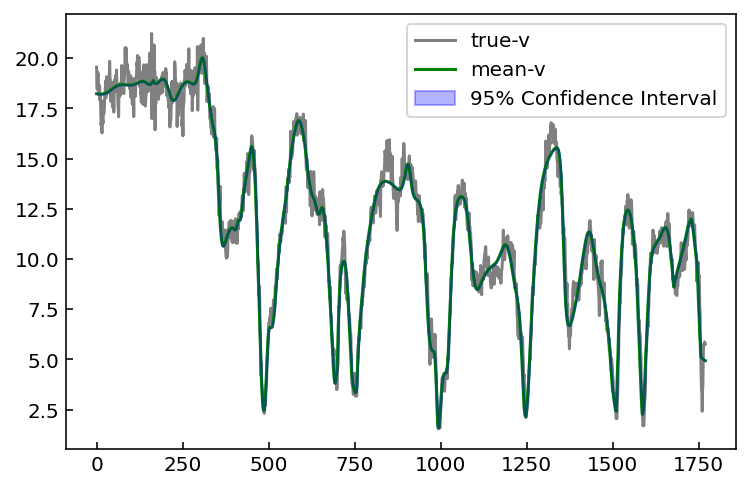

In [36]:
# 置信水平（这里使用95%置信水平）
confidence_level = 0.95 # 1.96; 85% -> 1.44
# 计算标准差（方差的平方根）
std_dev = np.sqrt(test_var)

# 计算置信区间的上下界
margin_of_error = 1.96 * (test_var_1 / np.sqrt(10))  # 对应95%置信水平的Z值
lower_bound = test_mean_1 - margin_of_error
upper_bound = test_mean_1 + margin_of_error

# ini_state_rho = density[:,19]
ini_state_v = speed[:,19]
# mean_rho = test_mean[:,19]
mean_v = test_mean_1[:,19]
lower_bound_1 = lower_bound[:,19]
upper_bound_1 = upper_bound[:,19]
plt.plot(range(len(ini_state_v)),ini_state_v,label = 'true-v',color="grey",zorder=1)
plt.plot(range(len(mean_v)),mean_v,label = 'mean-v',color='green')
# 绘制置信区间
plt.fill_between(range(len(mean_v)), lower_bound_1, upper_bound_1, color='blue', alpha=0.3, zorder=2,label='95% Confidence Interval')
plt.legend()
plt.savefig("Evolution.png", dpi=400, bbox_inches='tight')